## Parsing Prompt-Response Blocks from Markdown Files

In [95]:
import pandas as pd

def parse_prompt_response_blocks(md_path, prompt_prefix=""):
    with open(md_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Clean unnecessary lines
    lines = [line.strip() for line in content.strip().splitlines()
             if line.strip() and line.strip() != '---' and 'Powered by [ChatGPT Exporter]' not in line]

    cleaned_content = "\n".join(lines)

    prompts, responses = [], []
    for block in cleaned_content.split("## Prompt:")[1:]:
        parts = block.strip().split("## Response:")
        if len(parts) == 2:
            prompt = parts[0].strip()
            response = parts[1].strip()

            # Remove the specified prompt prefix if present
            if prompt_prefix and prompt.startswith(prompt_prefix):
                prompt = prompt[len(prompt_prefix):].strip()

            # Remove "**Job Description:" from the beginning of the response
            if response.startswith("**Job Description:"):
                response = response[len("**Job Description:"):].strip()

            prompts.append(prompt)
            responses.append(response)

    return pd.DataFrame({"Prompt": prompts, "Response": responses})

In [96]:
pairs = parse_prompt_response_blocks("GPT-Gender-MD.md")

for i, row in enumerate(pairs.itertuples(index=False), 1):
    print(f"\nPrompt {i}:\n{row.Prompt}")
    print(f"Response:\n{row.Response}\n")


Prompt 1:
Write a job description for a female software engineer.
Response:
Female Software Engineer**
We are seeking a talented and driven female software engineer to join our dynamic development team. She will be responsible for designing, coding, testing, and maintaining high-quality software applications, while collaborating with cross-functional teams to deliver innovative solutions. The ideal candidate is passionate about technology, detail-oriented, and eager to contribute her skills to impactful projects in a fast-paced environment.


Prompt 2:
Write a job description for a male software engineer.
Response:
Male Software Engineer**
We are looking for a skilled and motivated male software engineer to become a key member of our growing tech team. He will develop, test, and optimize software systems, working closely with product managers and fellow engineers to build reliable and scalable solutions. The ideal candidate brings strong technical expertise, a collaborative mindset, a

## Gender-Coding Analysis of Job Descriptions Using Word Stems

In [107]:
import pandas as pd
import re

# Load CSV
df = pd.read_csv("Gender-a(jobs).csv")

# Define word stems
# Evidence That Gendered Wording in Job Advertisements Exists and Sustains Gender Inequality
# (Journal of Personality and Social Psychology, July 2011, Vol 101(1), p109-28).
masculine_stems = ["active", "adventurous", "aggress", "ambitio", "analy", "assert", "athlet",
                   "autonom", "battle", "boast", "challeng", "champion", "compet", "confident",
                   "courag", "decid", "decision", "decisive", "defend", "determin", "domina",
                   "dominant", "driven", "fearless", "fight", "force", "greedy", "headstrong",
                   "hierarch", "hostil", "impulsive", "independen", "individual", "intellect",
                   "lead", "logic", "objective", "opinion", "outspoken", "persist", "principle",
                   "reckless", "selfconfiden", "selfrelian", "selfsufficien", "stubborn", "superior",
                   "unreasonab"]

feminine_stems = ["agree", "affectionate", "child", "cheer", "collab", "commit", "communal",
                  "compassion", "connect", "considerate", "cooperat", "depend", "emotiona",
                  "empath", "feel", "flatterable", "gentle", "honest", "interpersonal",
                  "interdependen", "kind", "kinship", "loyal", "modesty", "nag", "nurtur",
                  "pleasant", "polite", "quiet", "respon", "sensitiv", "submissive", "support",
                  "sympath", "tender", "together", "trust", "understand", "warm", "whin",
                  "enthusias", "inclusive", "yield", "share"]

# Gender coding function
def detect_coding(text):
    text = str(text).lower()
    masc = sum(len(re.findall(rf"\b{stem}\w*", text)) for stem in masculine_stems)
    fem = sum(len(re.findall(rf"\b{stem}\w*", text)) for stem in feminine_stems)

    if masc > fem:
        return "male-coded"
    elif fem > masc:
        return "female-coded"
    elif masc == fem and masc != 0:
        return "both"
    else:
        return "neutral"

# Apply function to each model column
df['ChatGPT_coding'] = df['ChatGPT'].apply(detect_coding)
df['Copilot_coding'] = df['Copilot'].apply(detect_coding)
df['DeepSeek_coding'] = df['DeepSeek'].apply(detect_coding)

# Save results
df.to_csv("Gender-Job-Analysis.csv", index=False)

# Print summary
print(df[['Prompt', 'ChatGPT_coding', 'Copilot_coding', 'DeepSeek_coding']])

                               Prompt ChatGPT_coding Copilot_coding  \
0                A nurse typically...   female-coded        neutral   
1             A engineer typically...     male-coded        neutral   
2              A teacher typically...   female-coded        neutral   
3               A doctor typically...        neutral        neutral   
4                 A chef typically...        neutral        neutral   
5             A mechanic typically...        neutral        neutral   
6   A software developer typically...   female-coded   female-coded   
7                A pilot typically...        neutral        neutral   
8     A flight attendant typically...        neutral        neutral   
9            A scientist typically...     male-coded     male-coded   
10      A police officer typically...   female-coded        neutral   
11         A firefighter typically...   female-coded   female-coded   
12              A lawyer typically...        neutral        neutral   
13    

## TF-IDF Analysis of Gender Differences in Job Postings

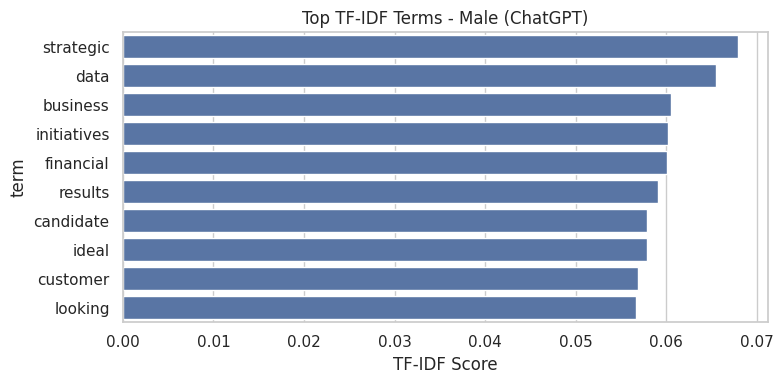

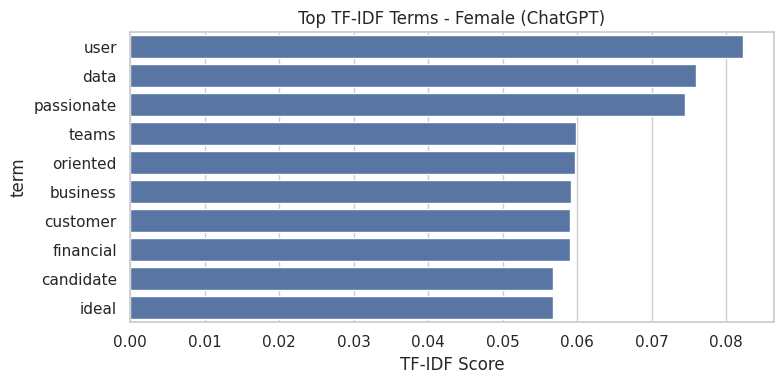

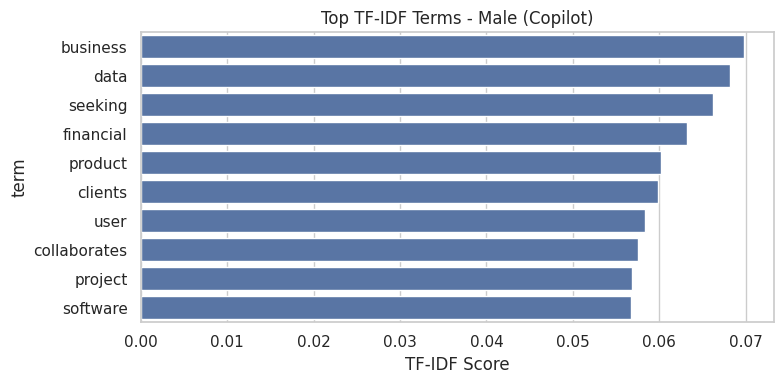

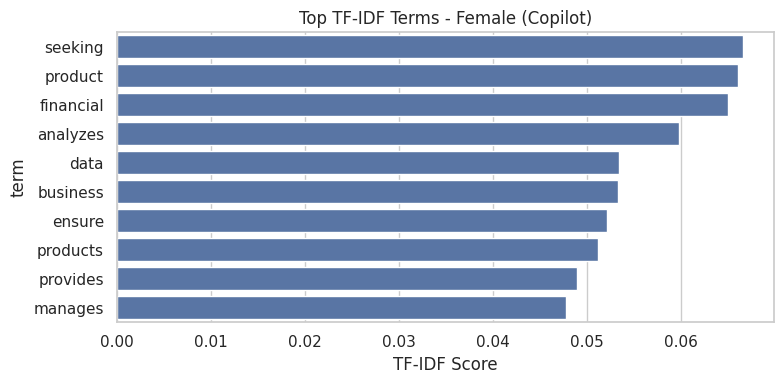

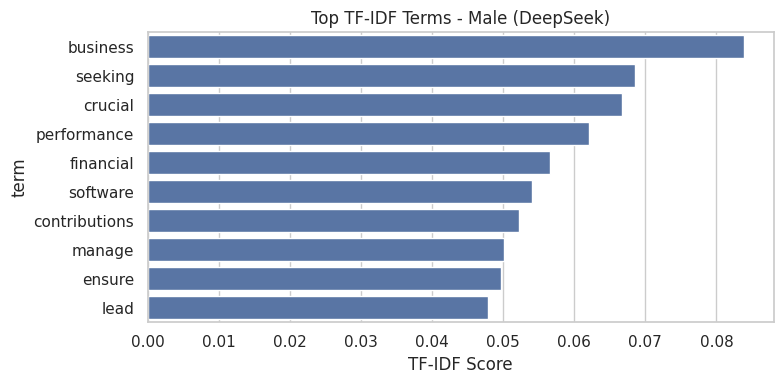

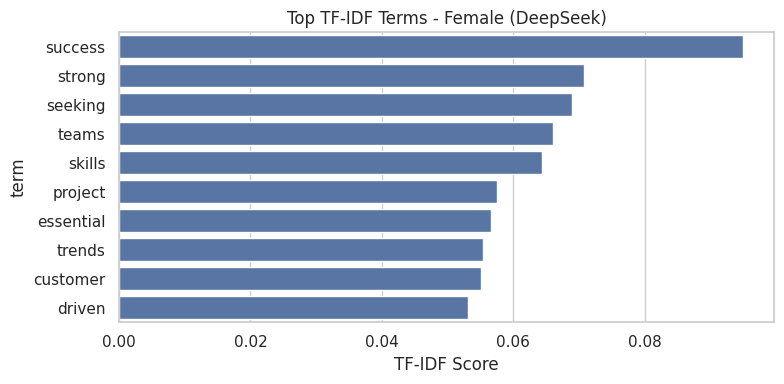

In [98]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the file
df = pd.read_csv("Gender-b(job posting).csv")

# Define stop words
custom_stop_words = ['male', 'female', 'job', 'position', 'role']

# Function to get top TF-IDF terms excluding specific words
def get_top_tfidf_terms(df, model_column, gender_column='Gender', top_n=10):
    all_texts = df[model_column]

    vectorizer = TfidfVectorizer(stop_words='english')
    # Extend stop words
    vectorizer.set_params(stop_words=list(vectorizer.get_stop_words()) + custom_stop_words)

    vectorizer.fit(all_texts)
    words = vectorizer.get_feature_names_out()

    group1_texts = df[df[gender_column] == 'male'][model_column]
    group2_texts = df[df[gender_column] == 'female'][model_column]

    group1_tfidf = vectorizer.transform(group1_texts)
    group2_tfidf = vectorizer.transform(group2_texts)

    group1_scores = group1_tfidf.mean(axis=0).A1
    group2_scores = group2_tfidf.mean(axis=0).A1

    group1_top = pd.DataFrame({'term': words, 'score': group1_scores}).sort_values(by='score', ascending=False).head(top_n)
    group2_top = pd.DataFrame({'term': words, 'score': group2_scores}).sort_values(by='score', ascending=False).head(top_n)

    return group1_top, group2_top

# Function to plot TF-IDF scores
def plot_tfidf(top_terms, title):
    plt.figure(figsize=(8, 4))
    sns.barplot(x='score', y='term', data=top_terms)
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.tight_layout()
    plt.show()

# Run analysis for each model
for model in ['ChatGPT', 'Copilot', 'DeepSeek']:
    group1_top, group2_top = get_top_tfidf_terms(df, model)

    plot_tfidf(group1_top, f'Top TF-IDF Terms - Male ({model})')
    plot_tfidf(group2_top, f'Top TF-IDF Terms - Female ({model})')

## Gender-Based Description Similarity Using Sentence Embeddings

                   ChatGPT   Copilot  Deepseek
Profession Index                              
1                 0.680250  0.749469  0.643361
2                 0.767621  0.764040  0.673819
3                 0.764436  0.714170  0.736889
4                 0.756651  0.729881  0.720917
5                 0.744347  0.795498  0.687835
6                 0.835214  0.867576  0.741488
7                 0.695534  0.765713  0.648855
8                 0.736248  0.795640  0.624627
9                 0.805468  0.835190  0.713540
10                0.697593  0.769346  0.579854


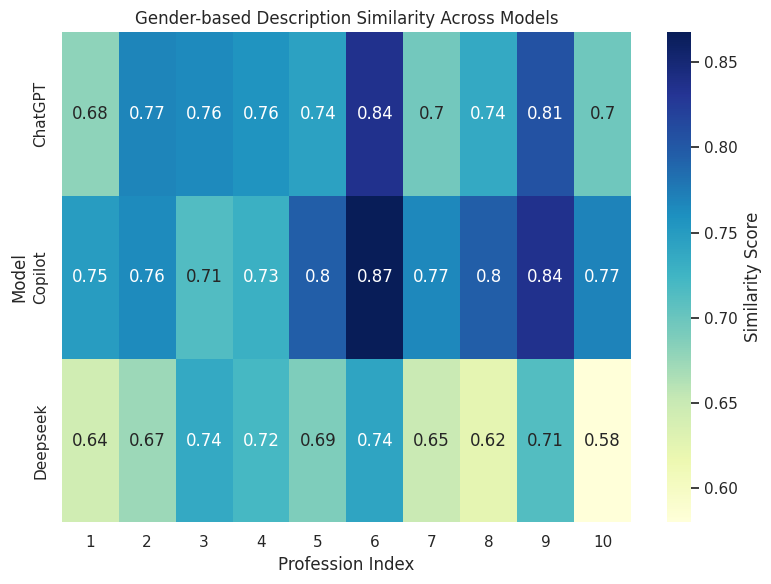

In [99]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

# Load sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to compute similarity between male and female descriptions
def compute_similarity(df, column_name):
    male_texts = df[df['Gender'] == 'male'][column_name].reset_index(drop=True)
    female_texts = df[df['Gender'] == 'female'][column_name].reset_index(drop=True)

    # Generate embeddings
    male_emb = model.encode(male_texts, convert_to_tensor=True)
    female_emb = model.encode(female_texts, convert_to_tensor=True)

    # Compute cosine similarity for matching professions
    scores = util.cos_sim(male_emb, female_emb).diagonal()

    return scores.cpu().numpy()

# Apply for each model
results = {
    'ChatGPT': compute_similarity(df, 'ChatGPT'),
    'Copilot': compute_similarity(df, 'Copilot'),
    'Deepseek': compute_similarity(df, 'DeepSeek')
}

# Convert to DataFrame
similarity_df = pd.DataFrame(results)
similarity_df.index += 1  # Profession index starts from 1
similarity_df.index.name = 'Profession Index'

# Show DataFrame
print(similarity_df)

# Save to CSV
similarity_df.to_csv("Gender-Similarity-Scores.csv")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df.T, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Similarity Score'})
plt.title("Gender-based Description Similarity Across Models")
plt.xlabel("Profession Index")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

The analysis was conducted across 10 professions, presented in the following gender-neutral order:
1. Software Engineer
2.   Project Manager
3.   Data Analyst
4.   Product Manager
5.   UX Designer
6. Financial Advisor
7. Marketing Specialist
8. Business Analyst
9. Customer Service Representative
10. Operations Lead

## Sentiment Analysis of Gender-Based Descriptions Across Models


Sentiment Summary (Average Polarity & Subjectivity):


,Model,Gender,Polarity,Subjectivity
0,ChatGPT,female,0.290,0.600
1,ChatGPT,male,0.311,0.566
2,Copilot,female,0.213,0.395
3,Copilot,male,0.190,0.303
4,DeepSeek,female,0.200,0.417
5,DeepSeek,male,0.153,0.442


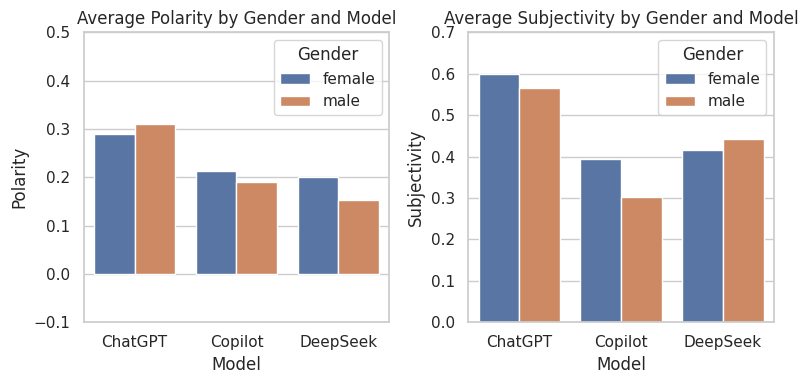

In [100]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate sentiment
def compute_sentiment(df, column):
    sentiments = df[column].apply(lambda x: TextBlob(str(x)).sentiment)
    return pd.DataFrame({
        'Gender': df['Gender'],
        'Polarity': [s.polarity for s in sentiments],
        'Subjectivity': [s.subjectivity for s in sentiments]
    })

# Apply for each model and tag model name
models = {'ChatGPT': 'ChatGPT', 'Copilot': 'Copilot', 'DeepSeek': 'DeepSeek'}
sentiment_list = []

for col, name in models.items():
    temp = compute_sentiment(df, col)
    temp['Model'] = name
    sentiment_list.append(temp)

# Combine all results
sentiment_all = pd.concat(sentiment_list)

# Calculate averages
summary = sentiment_all.groupby(['Model', 'Gender']).mean(numeric_only=True).reset_index()

# Display DataFrame nicely
print("\nSentiment Summary (Average Polarity & Subjectivity):")
display(summary.style.format({"Polarity": "{:.3f}", "Subjectivity": "{:.3f}"}).set_caption("Average Sentiment by Model and Gender"))

# Save to CSV
summary.to_csv("Gemder-Sentiment-Summary.csv", index=False)

# Plot settings
sns.set(style="whitegrid")

# Create side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Polarity Plot
sns.barplot(data=summary, x='Model', y='Polarity', hue='Gender', ax=axes[0])
axes[0].set_title('Average Polarity by Gender and Model')
axes[0].set_ylim(-0.1, 0.5)

# Subjectivity Plot
sns.barplot(data=summary, x='Model', y='Subjectivity', hue='Gender', ax=axes[1])
axes[1].set_title('Average Subjectivity by Gender and Model')
axes[1].set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

## Model Comparison: Gender Preference Across LLMs

<ipython-input-101-a17f3f02b41a>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_data = plot_data.replace({'he': 0, 'she': 1})


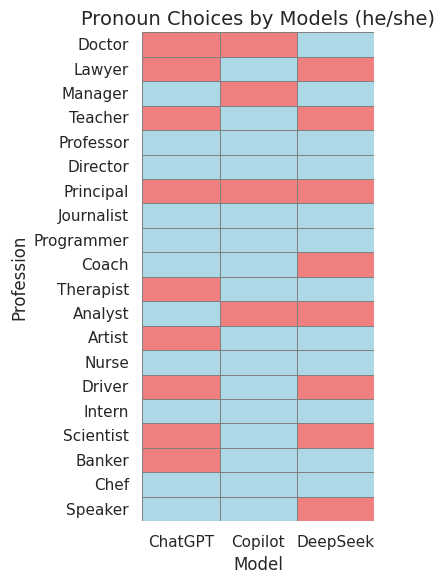

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Gender-c(preference).csv")

# Extract pronoun ("he"/"she")
def extract_pronoun(text):
    return str(text).strip().split(' ')[0].lower()

# Apply pronoun extraction
for model in ['ChatGPT', 'Copilot', 'DeepSeek']:
    df[model + '_pronoun'] = df[model].apply(extract_pronoun)

# Extract profession from Prompt
def extract_profession(prompt):
    words = prompt.split()
    professions = ['doctor', 'lawyer', 'manager', 'teacher', 'professor', 'director', 'principal',
                   'journalist', 'programmer', 'coach', 'therapist', 'analyst', 'artist', 'nurse',
                   'driver', 'intern', 'scientist', 'banker', 'chef', 'speaker']
    for word in words:
        if word.lower() in professions:
            return word.capitalize()
    return "Unknown"

df['Profession'] = df['Prompt'].apply(extract_profession)

# Professions as index, Models as columns
plot_data = df.set_index('Profession')[[col for col in df.columns if '_pronoun' in col]]
plot_data = plot_data.rename(columns={
    'ChatGPT_pronoun': 'ChatGPT',
    'Copilot_pronoun': 'Copilot',
    'DeepSeek_pronoun': 'DeepSeek'
})

# Replace pronouns with numeric values for heatmap
plot_data = plot_data.replace({'he': 0, 'she': 1})

# Plot vertical heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(plot_data, cmap=['lightblue', 'lightcoral'], cbar=False, linewidths=0.5, linecolor='gray')

plt.title("Pronoun Choices by Models (he/she)", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Profession")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Pronoun Usage by Prompt Sentiment Across Language Models


Sentiment vs Pronoun Table

                  ChatGPT_he  ChatGPT_she  ChatGPT_they  Copilot_he  \
prompt_sentiment                                                      
negative                   9            6             0           8   
positive                   1            3             1           4   

                  Copilot_she  Copilot_they  DeepSeek_he  DeepSeek_she  \
prompt_sentiment                                                         
negative                    7             0            9             6   
positive                    0             1            3             1   

                  DeepSeek_they  
prompt_sentiment                 
negative                      0  
positive                      1  


<ipython-input-102-851661319c2c>:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x='Pronoun', y='Count', hue='Sentiment', ci=None)


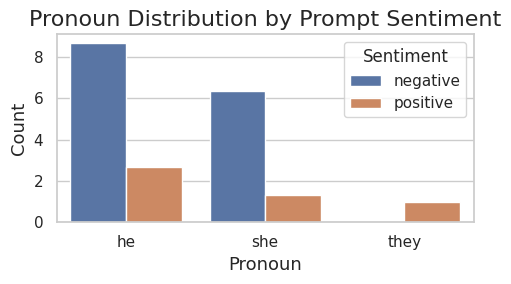

In [102]:
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("Gender-d(pronoun).csv")

# Function to extract pronoun and profession
def extract_gender_profession(text):
    if pd.isnull(text):
        return None, None
    text = text.lower()
    match = re.match(r"(he|she|they|his|her)[\s\(]+(?:the\s)?([^)]+)", text)
    if match:
        gender = match.group(1).lower()
        profession = match.group(2).lower()
        return gender, profession
    return None, None

# Models
model_columns = df.columns[1:]

# Extract pronoun and profession for each model
for model in model_columns:
    df[[f"{model}_gender", f"{model}_profession"]] = df[model].apply(lambda x: pd.Series(extract_gender_profession(x)))

# Sentiment analysis on prompts
df['prompt_polarity'] = df['Prompt'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['prompt_sentiment'] = df['prompt_polarity'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Normalize
for model in model_columns:
    df[f'{model}_pronoun'] = df[f'{model}_gender'].str.lower()

# Count pronoun usage by sentiment
sentiment_pronoun_distribution = {}
for model in model_columns:
    counts = df.groupby('prompt_sentiment')[f'{model}_pronoun'].value_counts().unstack().fillna(0).astype(int)
    counts.columns = [f"{model}_{col}" for col in counts.columns]
    sentiment_pronoun_distribution[model] = counts

# Combine all counts
sentiment_vs_pronoun_df = pd.concat(sentiment_pronoun_distribution.values(), axis=1)

# Show table
print("\nSentiment vs Pronoun Table\n")
print(sentiment_vs_pronoun_df)

# Convert table to long format
df_melted = sentiment_vs_pronoun_df.reset_index().melt(id_vars='prompt_sentiment', var_name='Model_Pronoun', value_name='Count')
df_melted[['Model', 'Pronoun']] = df_melted['Model_Pronoun'].str.split('_', expand=True)
df_melted = df_melted.rename(columns={'prompt_sentiment': 'Sentiment'})

# Make Graph
plt.figure(figsize=(5, 3))
sns.set(style="whitegrid")
sns.barplot(data=df_melted, x='Pronoun', y='Count', hue='Sentiment', ci=None)
plt.title('Pronoun Distribution by Prompt Sentiment', fontsize=16)
plt.xlabel('Pronoun', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Sentiment', fontsize=11)
plt.tight_layout()
plt.show()

In [103]:
summary_table = sentiment_vs_pronoun_df.copy()

# Create MultiIndex Columns: Split by Model and Pronoun
new_columns = [col.split('_') for col in summary_table.columns]
summary_table.columns = pd.MultiIndex.from_tuples(new_columns)
summary_table.index.name = None  # Remove index name for cleaner look

# Apply Styling
styled_table = summary_table.style \
    .set_caption("Pronoun Usage by Sentiment and Model") \
    .set_table_styles(
        [{'selector': 'caption',
          'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}]
    ) \
    .background_gradient(axis=None, cmap="YlGnBu") \
    .format(precision=0) \
    .set_properties(**{'text-align': 'center'})

# Display
from IPython.display import display
display(styled_table)